In [222]:
from IPython.display import display, HTML
display(HTML("<h1 style='color:Green;'>Random Forest (LIME)</h1>"))

# **ABALONE AGE PREDICTION**

Hiba Zubairi -  34779757

Wadiqa Baig -   34675845

Fatima Faisal - 34890984

Pooja Gurnani - 35059182


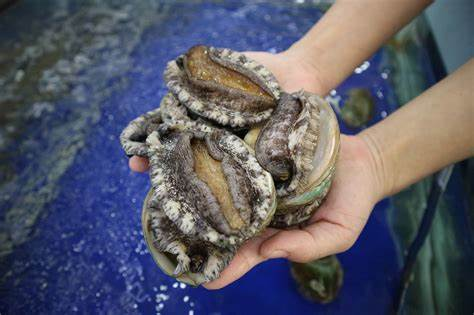

# 1. DATA COLLECTION

## 1.1 Import Required Libraries


In [223]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Scikit-learn modules for modeling and evaluation
from sklearn.model_selection import (train_test_split,
                                     GridSearchCV,
                                     StratifiedKFold,
                                     cross_val_score,
                                     learning_curve)

from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score,
                             classification_report,
                             confusion_matrix,
                             ConfusionMatrixDisplay,
                             roc_curve,
                             auc,
                             roc_auc_score)

# Imbalanced-learn for pipeline
from imblearn.pipeline import Pipeline

## 1.2 Load Dataset

In [224]:
# Load the Abalone dataset from UCI
df = pd.read_csv('https://archive.ics.uci.edu/static/public/1/data.csv')

df.head()

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [225]:
# Check dataset dimensions (rows, columns)
print(df.shape)

(4177, 9)


In [226]:
# Display data types and non-null counts for each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole_weight    4177 non-null   float64
 5   Shucked_weight  4177 non-null   float64
 6   Viscera_weight  4177 non-null   float64
 7   Shell_weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


# 2. EXPLORATORY DATA ANALYSIS

## Plot 1: Relationship between Whole Weight and Rings (Age)

Text(0.5, 0, 'Whole weight')

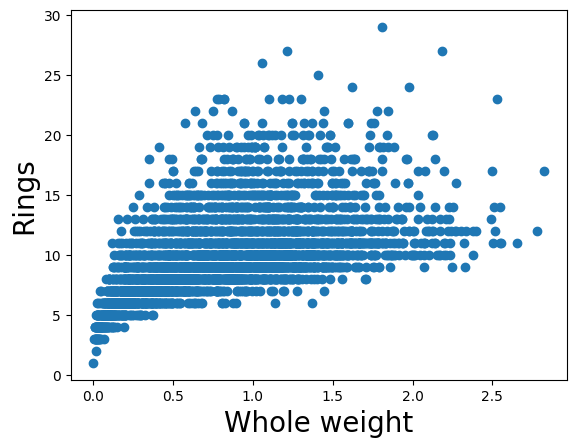

In [227]:
plt.scatter(df  ['Whole_weight'], df['Rings'])
plt.ylabel('Rings', size=20)
plt.xlabel('Whole weight', size=20)

**Observation:**

There is a clear positive correlation between whole weight and the number of rings, which aligns with the expectation that older abalones tend to be larger and heavier.

---



## Plot 2: Age Distribution by Sex

Text(0.5, 0, 'Sex')

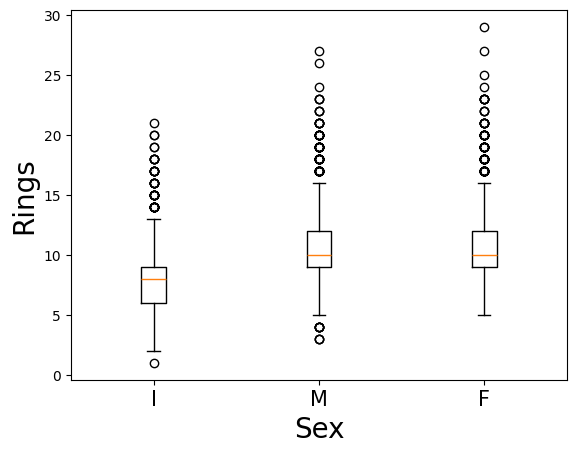

In [228]:
# Filter the DataFrame for each sex and plot the 'Rings' column
plt.boxplot(df[df['Sex']=='I']['Rings'], positions=[1])
plt.boxplot(df[df['Sex']=='M']['Rings'], positions=[2])
plt.boxplot(df[df['Sex']=='F']['Rings'], positions=[3])

plt.xticks([1, 2, 3], labels=['I', 'M', 'F'],size= 15)
plt.ylabel('Rings', size=20)
plt.xlabel('Sex', size=20)

**Observation:**

Infants (I) generally have a lower number of rings, indicating a younger age. In contrast, there is minimal difference in the number of rings between Males (M) and Females (F), suggesting similar age distributions across these two groups.

---



## Plot 3: Feature Correlation Analysis

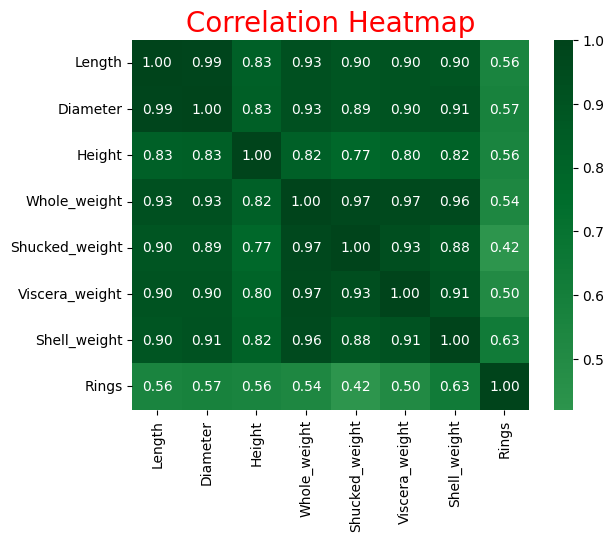

In [229]:
cont = ["Length", "Diameter", "Height",
       "Whole_weight", "Shucked_weight",
       "Viscera_weight", "Shell_weight", "Rings"]


corr_matrix = pd.DataFrame(df[cont],columns=cont).corr()

sns.heatmap(corr_matrix,
            annot=True,
            center=0,
            cmap='Greens',
            fmt='.2f')
plt.title('Correlation Heatmap',  color="red", size=20)
plt.show()

**Observation:**

Length and diameter are perfectly correlated, indicating a strong linear relationship between these two size measurements. Additionally, whole weight shows a high correlation with other weight-related features such as shucked weight, viscera weight, and shell weight, suggesting that as the abalone’s total mass increases, its component weights increase proportionally.

---



# 3. DATA PREPROCESSING

##3.1 Handle Multicollinearity

Since length and diameter are perfectly correlated, one of them (e.g., diameter) can be **dropped to avoid redundancy**.

Similarly, due to the high correlation between whole weight and other weight-related features (shucked weight, viscera weight, shell weight), we can consider dropping **whole weight** to reduce multicollinearity.

In [230]:
df = df.drop(['Diameter', 'Whole_weight'], axis=1)

#Show remaining features
print("Remaining features after dropping:")
print(df.columns.tolist())

Remaining features after dropping:
['Sex', 'Length', 'Height', 'Shucked_weight', 'Viscera_weight', 'Shell_weight', 'Rings']


## 3.2 Missing Value Analysis

Check for null values

In [231]:
print("Null values per column:")
df.isnull().sum()

Null values per column:


,0
Sex,0
Length,0
Height,0
Shucked_weight,0
Viscera_weight,0
Shell_weight,0
Rings,0


Check for zero values (potential data quality issues)

In [232]:
print("\nZero values per column:")
((df) == 0).sum()


Zero values per column:


,0
Sex,0
Length,0
Height,2
Shucked_weight,0
Viscera_weight,0
Shell_weight,0
Rings,0


**Note**: Height contains 2 zero values, which are likely data entry errors
since physical height should be positive.


---



In [233]:
# Examine records with zero height
df[df['Height']==0]

,Sex,Length,Height,Shucked_weight,Viscera_weight,Shell_weight,Rings
1257,I,0.430,0.0,0.2065,0.0860,0.1150,8
3996,I,0.315,0.0,0.0575,0.0285,0.3505,6



---

The two zero values in the Height column were replaced with the **mean height** of the remaining (non-zero) entries to handle potential data entry errors and maintain data consistency.

## 3.3 Handle Zero Values in Height

In [234]:
# Calculate mean height by sex category for imputation
means = pd.pivot_table(df, index=['Sex'], aggfunc={'Height' :np.mean})
means

<ipython-input-234-19286ec419de>:2: FutureWarning: The provided callable <function mean at 0x79b18ba02340> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  means = pd.pivot_table(df, index=['Sex'], aggfunc={'Height' :np.mean})


,Height
Sex,
F,0.158011
I,0.107996
M,0.151381


In [235]:
# Replace zero heights with overall mean (more conservative approach)
df['Height'] = df['Height'].replace(to_replace=0, value=0.107996)

Verify zero values are handled

In [236]:
((df) == 0).sum()

,0
Sex,0
Length,0
Height,0
Shucked_weight,0
Viscera_weight,0
Shell_weight,0
Rings,0


## 3.4 Encode Categorical Variables

In [237]:
# Convert Sex categories to dummy variables (one-hot encoding)
df = pd.get_dummies(df, dtype=int)
df

,Length,Height,Shucked_weight,Viscera_weight,Shell_weight,Rings,Sex_F,Sex_I,Sex_M
0,0.455,0.095,0.2245,0.1010,0.1500,15,0,0,1
1,0.350,0.090,0.0995,0.0485,0.0700,7,0,0,1
2,0.530,0.135,0.2565,0.1415,0.2100,9,1,0,0
3,0.440,0.125,0.2155,0.1140,0.1550,10,0,0,1
4,0.330,0.080,0.0895,0.0395,0.0550,7,0,1,0
...,...,...,...,...,...,...,...,...,...
4172,0.565,0.165,0.3700,0.2390,0.2490,11,1,0,0
4173,0.590,0.135,0.4390,0.2145,0.2605,10,0,0,1
4174,0.600,0.205,0.5255,0.2875,0.3080,9,0,0,1
4175,0.625,0.150,0.5310,0.2610,0.2960,10,1,0,0


##3.5 Create Binary Target Variable

In [238]:
# Add an “Age_Group” column: Old= 1, Young= 0

# Define a function to label each abalone
def label_age_group(rings):
    if rings < 9:
        return 0  # Young
    else:
        return 1  # Old

# Apply the function to create a new column
df['Age_Group'] = df['Rings'].apply(label_age_group)

#Print
count_young = df['Age_Group'].value_counts()[0]
count_old = df['Age_Group'].value_counts()[1]

print(f"Number of young abalones: {count_young}")
print(f"Number of   old abalones: {count_old}")

df.head()

Number of young abalones: 1407
Number of   old abalones: 2770


,Length,Height,Shucked_weight,Viscera_weight,Shell_weight,Rings,Sex_F,Sex_I,Sex_M,Age_Group
0,0.455,0.095,0.2245,0.1010,0.150,15,0,0,1,1
1,0.350,0.090,0.0995,0.0485,0.070,7,0,0,1,0
2,0.530,0.135,0.2565,0.1415,0.210,9,1,0,0,1
3,0.440,0.125,0.2155,0.1140,0.155,10,0,0,1,1
4,0.330,0.080,0.0895,0.0395,0.055,7,0,1,0,0


## 3.6 Prepare Features and Target

Assign X → the features (independent variables used to predict)

Assign y → the target (dependent variable to be predicted)

In [239]:
# Separate features (X) and target (y)
X = df.drop(columns=['Rings', 'Age_Group']) # Drop Age, Rings, and the target variable Age_Group from features
y = df['Age_Group']

In [240]:
print("Features:", list(X.columns))
print("Target:", y.name)

Features: ['Length', 'Height', 'Shucked_weight', 'Viscera_weight', 'Shell_weight', 'Sex_F', 'Sex_I', 'Sex_M']
Target: Age_Group


# 4. DATA SPLITTING


In [241]:
# Split 80% train, 20% temp (to later split into test and validation)

# First split: 80% train, 20% temporary
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.2,           # 20% for temp (val + test)
    random_state=42
)

# Split 10% test, 10% validation from the temp (which is 20% of original)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,           # 50% of 20% = 10% each
    random_state=42
)



#5. CROSS-VALIDATION SETUP

In [242]:
# Configure stratified k-fold cross-validation
cv = StratifiedKFold(n_splits=10,      # 10-fold CV
                     shuffle=True,      # Shuffle data before splitting
                     random_state=42)   # Reproducible results

#6. MODEL PIPELINE CONSTRUCTION

In [243]:
# Define hyperparameter search space
pipe = Pipeline([
    # Step 1: Feature scaling (standardization)
    ('scaler', StandardScaler()),
    # Step 2: Random Forest with initial parameters
    ('randomfor', RandomForestClassifier(n_estimators=100,
                                         max_depth=8,
                                         min_samples_split=10,
                                         min_samples_leaf=10,
                                         max_features=0.5,
                                         random_state=42))
])

#7. HYPERPARAMETER OPTIMISATION

In [244]:
param_grid = {
    'randomfor__n_estimators': [50,100],
    'randomfor__max_depth': [3, 5,8],
    'randomfor__min_samples_split': [10, 20],
    'randomfor__min_samples_leaf': [5, 10],
    'randomfor__max_features': ['sqrt', 0.5]
}

#Grid search with CV
grid = GridSearchCV(pipe,
                    param_grid,
                    cv=10,
                    scoring='accuracy'
                    )

# Fit the grid search to the training data BEFORE accessing best_estimator_
grid.fit(X_train, y_train)

# Now you can safely access best_estimator_
best_model = grid.best_estimator_

# Corrected the variable name in the print statement
print("Best Parameters:", grid.best_params_)

Best Parameters: {'randomfor__max_depth': 8, 'randomfor__max_features': 0.5, 'randomfor__min_samples_leaf': 10, 'randomfor__min_samples_split': 10, 'randomfor__n_estimators': 100}


# 8. MODEL EVALUATION

## 8.1 Validation Set Performance

In [245]:
val_preds = grid.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, val_preds))
print("Validation Classification Report:\n", classification_report(y_val, val_preds))

Validation Accuracy: 0.8325358851674641
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.69      0.73       140
           1       0.85      0.90      0.88       278

    accuracy                           0.83       418
   macro avg       0.82      0.80      0.81       418
weighted avg       0.83      0.83      0.83       418



## 8.2 Test Set Performance (Final Evaluation)

In [246]:
test_preds = grid.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, test_preds))
print("Test Classification Report:\n", classification_report(y_test, test_preds))

Test Accuracy: 0.854066985645933
Test Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.69      0.76       139
           1       0.86      0.94      0.90       279

    accuracy                           0.85       418
   macro avg       0.85      0.81      0.83       418
weighted avg       0.85      0.85      0.85       418



#9. CONFUSION MATRIX ANALYSIS

Correct Predictions: 357/418
Accuracy: 85.41%
Error: 14.59%


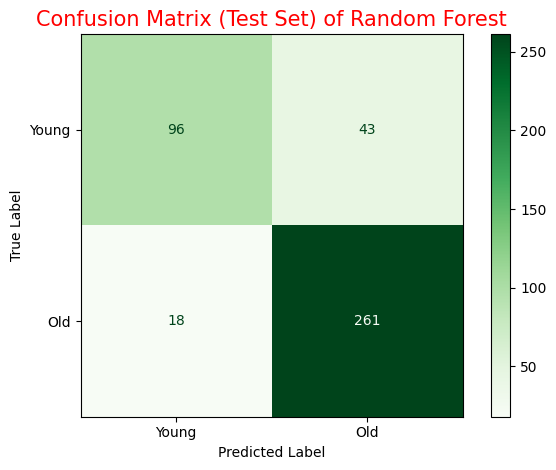

In [247]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, test_preds)

# Correct predictions (sum of the diagonal)
correct_predictions = np.trace(cm)

# Total predictions
total_predictions = np.sum(cm)

# Incorrect predictions
incorrect_predictions = total_predictions - correct_predictions

# Accuracy and error
accuracy_percentage = (correct_predictions / total_predictions) * 100
error_percentage = (incorrect_predictions / total_predictions) * 100

# Display
print(f"Correct Predictions: {correct_predictions}/{total_predictions}")
print(f"Accuracy: {accuracy_percentage:.2f}%")
print(f"Error: {error_percentage:.2f}%")

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Young", "Old"])
disp.plot(cmap="Greens", values_format='d')

plt.title("Confusion Matrix (Test Set) of Random Forest",  color= "red", size=15)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.grid(False)
plt.tight_layout()
plt.show()

# 10. ROC CURVE AND AUC ANALYSIS

AUC Score: 0.9313581392950157


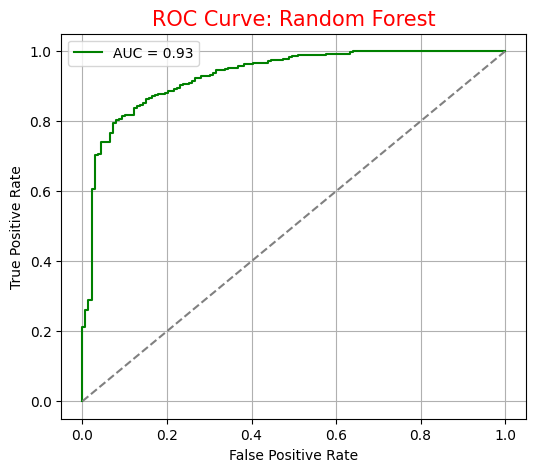

In [248]:
# Use the best model found by GridSearchCV
y_pred_prob = grid.best_estimator_.predict_proba(X_test)[:, 1]

# Calculate the false positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculate the AUC score
auc_score = roc_auc_score(y_test, y_pred_prob)
print("AUC Score:", auc_score)

# Plot the ROC curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}", color='green')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Random Forest', color= "red", size=15)
plt.grid(True)
plt.legend()
plt.show()


# 11. VALIDATION VS TEST ACCURACY COMPARISON

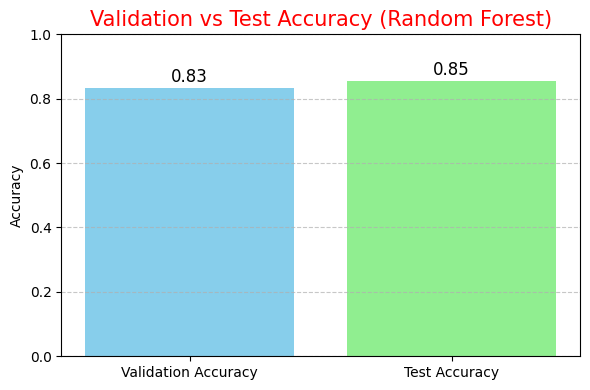

In [249]:
# Predictions
val_preds = best_model.predict(X_val)
test_preds = best_model.predict(X_test)

# Accuracies
val_accuracy = accuracy_score(y_val, val_preds)
test_accuracy = accuracy_score(y_test, test_preds)

# Plot
plt.figure(figsize=(6, 4))
plt.bar(['Validation Accuracy', 'Test Accuracy'], [val_accuracy, test_accuracy], color=['skyblue', 'lightgreen'])
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Validation vs Test Accuracy (Random Forest)', color= "red", size=15)
for i, acc in enumerate([val_accuracy, test_accuracy]):
    plt.text(i, acc + 0.02, f"{acc:.2f}", ha='center', fontsize=12)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# 12. LEARNING CURVE ANALYSIS

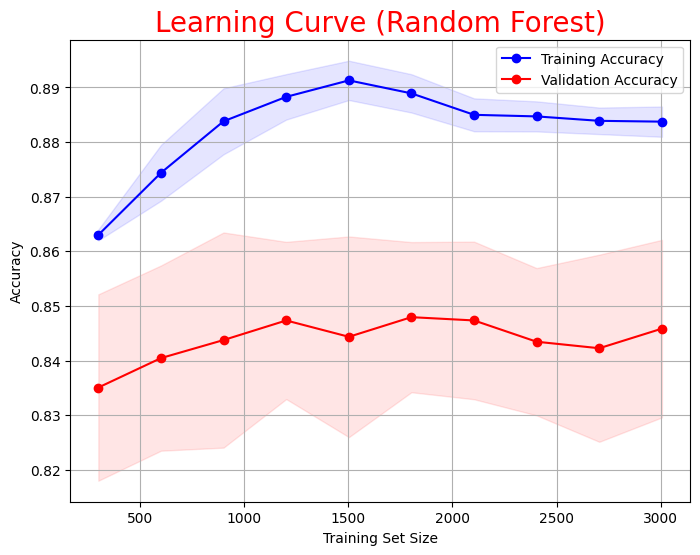

Train scores:
 [[0.86       0.86333333 0.86333333 0.86333333 0.86333333 0.86333333
  0.86333333 0.86333333 0.86333333 0.86333333]
 [0.88685524 0.88186356 0.8718802  0.8718802  0.8718802  0.8718802
  0.8718802  0.8718802  0.8718802  0.8718802 ]
 [0.89678135 0.89345172 0.88679245 0.88013319 0.88013319 0.88013319
  0.88013319 0.88013319 0.88013319 0.88013319]
 [0.8985025  0.89351082 0.88935108 0.88519135 0.88602329 0.88602329
  0.88602329 0.88602329 0.88602329 0.88602329]
 [0.89221557 0.88689288 0.89155023 0.88489687 0.88622754 0.89421158
  0.89421158 0.89421158 0.89421158 0.89421158]
 [0.88574598 0.88851913 0.88241819 0.88574598 0.8879645  0.89572934
  0.89073766 0.89073766 0.89073766 0.89073766]
 [0.87975285 0.8845057  0.88498099 0.88307985 0.88022814 0.88688213
  0.88545627 0.88830798 0.88830798 0.88830798]
 [0.88768719 0.88519135 0.88727121 0.88103161 0.88560732 0.88976705
  0.88352745 0.88311148 0.88186356 0.88186356]
 [0.88243993 0.88280961 0.88170055 0.88207024 0.88465804 0.8887245

In [250]:
# Use the best estimator from GridSearchCV for the learning curve
best_model = grid.best_estimator_


# Generate learning curve data using the same model and parameters
train_sizes, train_scores, test_scores = learning_curve(best_model, X_train, y_train,
                                                        cv=10,
                                                        scoring='accuracy',
                                                        train_sizes=np.linspace(0.1, 1.0, 10))

# Calculate mean and standard deviation of training and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(8, 6))

plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Accuracy')
plt.plot(train_sizes, test_mean, 'o-', color='red', label='Validation Accuracy')

# Plot shaded regions for standard deviation
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='red', alpha=0.1)

plt.title('Learning Curve (Random Forest)', size=20, color="red")
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.show()
print("Train scores:\n", train_scores)
print("Train mean:\n", train_mean)


Training accuracy ranges from 85-88%

validation accuracy remains consistent around 81-82%

(250-1000 samples): Both training and validation accuracy improve as more data is added, showing the model is actually learning patterns.

(1000+ samples): Performance stabilizes, suggesting we have reached the model's capacity for this dataset.



The small gap between training and validation curves indicates the model generalizes well to unseen data.

# 13. MODEL EXPLAINABILITY (LIME ANALYSIS)

In [251]:
!pip install lime
import lime
import lime.lime_tabular
from lime.lime_tabular import LimeTabularExplainer


## 13.1 Create the LIME explainer

In [252]:
# Set up the explainer for classification
explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns.tolist(),
    class_names=['Young', 'Old'],  # Your binary target classes
    mode='classification',
    verbose=True,
    random_state=42,
    discretize_continuous=True
)


## 13.2 Explaining one instance

In [253]:
# Explain one test instance (e.g., index 0)
i = 0
exp = explainer.explain_instance(
    data_row=X_test.iloc[i],
    predict_fn=grid.predict_proba,  #returns the probability estimates for each class for a given input sample.
    num_features=8
)

# Add a title above the LIME explanation
display(HTML("<h1 style='color:red;'>LIME Explanation for Test Instance 0</h2>"))

# Show explanation in notebook
exp.show_in_notebook(show_table=True, show_predicted_value=False)

# Print the predicted class
print("Predicted Class:", grid.predict([X_test.iloc[i]])[0])
print("Actual Class:", y_test.iloc[i])


Intercept 0.8082686225379083
Prediction_local [0.28352838]
Right: 0.206255237504253


/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

Predicted Class: 0
Actual Class: 1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


## 13.2 Aggregate Weights

### Extract explanation Weights

In [254]:
def return_weights(exp, class_index=1):  # Class index 1 = 'Old'
    """Extract weights for a specific class from LIME explanation"""
    exp_list = exp.as_map()[class_index]
    exp_list = sorted(exp_list, key=lambda x: x[0])
    exp_weight = [x[1] for x in exp_list]
    return exp_weight


### Apply to first 100 test samples

In [255]:
weights = []

# Iterate over first 100 rows
for i in range(100):
    x_instance = X_test.iloc[i]
    exp = explainer.explain_instance(x_instance,
                                     best_model.predict_proba,
                                     num_features=8,
                                     labels=[1])  # Ask LIME to explain Class 1

    exp_weight = return_weights(exp, class_index=1)  # Class 1 = 'Old'
    weights.append(exp_weight)

# Convert to DataFrame
lime_weights = pd.DataFrame(weights, columns=X_test.columns[:len(weights[0])])


/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

Intercept 0.8106175070961504
Prediction_local [0.28737102]
Right: 0.206255237504253


/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

Intercept 0.6753102157162956
Prediction_local [0.60174386]
Right: 0.601481708408061


/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  binary_column = (inverse_column == first_row[column]).astype(int)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__se

Intercept 0.6483946220146367
Prediction_local [0.68035254]
Right: 0.6702175304167928


/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

Intercept 0.8146295878306813
Prediction_local [0.2826439]
Right: 0.02367976034301535


/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

Intercept 0.5936033439705755
Prediction_local [0.84375832]
Right: 0.9587697217479143
Intercept 0.8157991453824432
Prediction_local [0.27886404]
Right: 0.09768788942236824


/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  discretized_instance[f])]
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = in

Intercept 0.5698752136826637
Prediction_local [0.91417826]
Right: 0.9961767545275625


/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

Intercept 0.6113198227436112
Prediction_local [0.77560714]
Right: 0.6800283309139256
Intercept 0.6009761538666997
Prediction_local [0.84064959]
Right: 0.9804163521567603


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem

Intercept 0.5832405827385599
Prediction_local [0.89006698]
Right: 0.9530653908132265
Intercept 0.5542176681732737
Prediction_local [0.97160178]
Right: 0.9910054018147689


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem

Intercept 0.5689551800319879
Prediction_local [0.9183168]
Right: 0.9791969933994926
Intercept 0.8198365727164272
Prediction_local [0.27376505]
Right: 0.007628957207147952


/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

Intercept 0.6698676620998657
Prediction_local [0.63692515]
Right: 0.961119588449717
Intercept 0.6086060141133883
Prediction_local [0.83875996]
Right: 0.8619422086688037


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem

Intercept 0.7059881406860414
Prediction_local [0.60217472]
Right: 0.5991646439201971


/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

Intercept 0.8184319579176333
Prediction_local [0.2851253]
Right: 0.2049136929938025


/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

Intercept 0.6001115417929163
Prediction_local [0.78807786]
Right: 0.8780078753785635


/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

Intercept 0.6007617951531471
Prediction_local [0.84531123]
Right: 0.8499290332301795


/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

Intercept 0.5589224091816039
Prediction_local [0.93107066]
Right: 0.9578126188931279
Intercept 0.5791248634283651
Prediction_local [0.89535599]
Right: 0.9664094040254503


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem

Intercept 0.8218491085794029
Prediction_local [0.26949254]
Right: 0.025521872576852636


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem

Intercept 0.8184599935106198
Prediction_local [0.26779017]
Right: 0.075332551353314


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem

Intercept 0.6018742715371356
Prediction_local [0.84249163]
Right: 0.7864076233219288


/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

Intercept 0.6041434983430986
Prediction_local [0.82009978]
Right: 0.764513578393466
Intercept 0.8173521260824277
Prediction_local [0.27044459]
Right: 0.060957312898191666
Intercept 0.576395930678322
Prediction_local [0.90214122]
Right: 0.9778849054730263


/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

Intercept 0.7596705305709197
Prediction_local [0.3429165]
Right: 0.4371178614411282
Intercept 0.5897175682642296
Prediction_local [0.86644297]
Right: 0.9392086275487047


/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

Intercept 0.5772984246224266
Prediction_local [0.92776642]
Right: 0.9997643161530001
Intercept 0.5873237482456999
Prediction_local [0.84789037]
Right: 0.9471272988053043


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem

Intercept 0.8122840213202493
Prediction_local [0.28272645]
Right: 0.06055294556069063
Intercept 0.571937309986529
Prediction_local [0.92914151]
Right: 0.9890249129267903


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem

Intercept 0.5771574837181261
Prediction_local [0.87998009]
Right: 0.7381907503629901
Intercept 0.8229024962386737
Prediction_local [0.26795365]
Right: 0.030963468136517944


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem

Intercept 0.5633299882069798
Prediction_local [0.92712991]
Right: 0.9893858614533743


/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

Intercept 0.5865550101401854
Prediction_local [0.86369793]
Right: 0.9431680401714599


/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

Intercept 0.6594812341903675
Prediction_local [0.7306335]
Right: 0.7487728522191455
Intercept 0.8219995286344791
Prediction_local [0.26889209]
Right: 0.06516479549113505


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem

Intercept 0.593466904844493
Prediction_local [0.87103423]
Right: 0.968515413552629
Intercept 0.6614489756272954
Prediction_local [0.64019616]
Right: 0.6918808960988098


/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

Intercept 0.565010000005038
Prediction_local [0.92417072]
Right: 0.9997200278971214
Intercept 0.5775751556776801
Prediction_local [0.89915755]
Right: 0.9538310145626424


/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

Intercept 0.5682125254515489
Prediction_local [0.91332173]
Right: 0.9766076389442108
Intercept 0.7723862262651138
Prediction_local [0.33420469]
Right: 0.6030577352572081


/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

Intercept 0.8179691387316539
Prediction_local [0.26870032]
Right: 0.00010582010582010581
Intercept 0.5815853134272716
Prediction_local [0.86081607]
Right: 0.907735905752191


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem

Intercept 0.8459841700878501
Prediction_local [0.19544513]
Right: 0.06732553042861576
Intercept 0.59345007780613
Prediction_local [0.82208191]
Right: 0.7076415406718606


/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

Intercept 0.5640543947566918
Prediction_local [0.89320471]
Right: 0.9694446478899025


/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

Intercept 0.6771153108853609
Prediction_local [0.64757296]
Right: 0.7982486750289144
Intercept 0.7649469990337443
Prediction_local [0.3331866]
Right: 0.4981898236346941


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem

Intercept 0.8061903258582018
Prediction_local [0.29060241]
Right: 0.069505294055079
Intercept 0.8249862870208892
Prediction_local [0.26169569]
Right: 0.14572838974003122


/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

Intercept 0.8153677135889172
Prediction_local [0.2855247]
Right: 0.21745818294612845


/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

Intercept 0.816832371012544
Prediction_local [0.26985835]
Right: 0.0009240019240019239
Intercept 0.5850136885175317
Prediction_local [0.85814351]
Right: 0.8533109768814344


/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

Intercept 0.610081915207799
Prediction_local [0.83263741]
Right: 0.9370890579626062
Intercept 0.6194499899983211
Prediction_local [0.72828281]
Right: 0.9461098314631116


/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

Intercept 0.5679774497251795
Prediction_local [0.89059459]
Right: 0.9430874400134354
Intercept 0.5944308417338647
Prediction_local [0.82012563]
Right: 0.7961649190239898


/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

Intercept 0.5551633834327817
Prediction_local [0.93565207]
Right: 0.9381907374113467
Intercept 0.5605141989380921
Prediction_local [0.96020697]
Right: 0.965272534548717


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem

Intercept 0.8155075188490589
Prediction_local [0.28177412]
Right: 0.03695396636135176
Intercept 0.8185701415901165
Prediction_local [0.28413377]
Right: 0.00010582010582010581


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem

Intercept 0.7382554577224918
Prediction_local [0.52479372]
Right: 0.42301101306565947
Intercept 0.7583634202317153
Prediction_local [0.37777737]
Right: 0.5592706612805206


/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

Intercept 0.5879405534019821
Prediction_local [0.86103137]
Right: 0.6959853218834499
Intercept 0.8067661539026437
Prediction_local [0.29343386]
Right: 0.0009240019240019239


/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

Intercept 0.5974315848319476
Prediction_local [0.84708748]
Right: 0.9443993407260217


/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

Intercept 0.6496128089416303
Prediction_local [0.6918202]
Right: 0.937488518525039
Intercept 0.8187826473929951
Prediction_local [0.2774699]
Right: 0.018655672138267475


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem

Intercept 0.8156752817409264
Prediction_local [0.2753503]
Right: 0.15354556570334588


/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

Intercept 0.6427890868352344
Prediction_local [0.69097142]
Right: 0.6072195601160162
Intercept 0.5883435496923451
Prediction_local [0.84912998]
Right: 0.945170469882078


/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

Intercept 0.6365953699051533
Prediction_local [0.6963807]
Right: 0.8536983104278021
Intercept 0.8162800758928783
Prediction_local [0.27784374]
Right: 0.2992463312122496


/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

Intercept 0.577619936423578
Prediction_local [0.8647415]
Right: 0.8966015931509387
Intercept 0.6589980885069034
Prediction_local [0.68004204]
Right: 0.8559722383117859


/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

Intercept 0.5720435107391938
Prediction_local [0.89818411]
Right: 0.9424174831436912
Intercept 0.5605780672521269
Prediction_local [0.90529996]
Right: 0.9846545804144127


/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

Intercept 0.5851498251056216
Prediction_local [0.86264136]
Right: 0.970194073520019
Intercept 0.5897515155650411
Prediction_local [0.86209675]
Right: 0.8716486181851851


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem

Intercept 0.5733378222709364
Prediction_local [0.91721723]
Right: 0.9878969717051588
Intercept 0.5998775310794243
Prediction_local [0.8241797]
Right: 0.727180589679625


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem

Intercept 0.5641005304289765
Prediction_local [0.91683324]
Right: 0.9720847406844503
Intercept 0.6108530382746501
Prediction_local [0.81257375]
Right: 0.9204963548038642


/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

Intercept 0.7670891563590737
Prediction_local [0.32720425]
Right: 0.6670366266169658
Intercept 0.5580249556755507
Prediction_local [0.93708381]
Right: 0.9591394936009423


/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

Intercept 0.6054639281465446
Prediction_local [0.8323471]
Right: 0.9447212086655468
Intercept 0.7348343394160632
Prediction_local [0.52508873]
Right: 0.23420772613359553


/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

Intercept 0.5976894109558113
Prediction_local [0.82712435]
Right: 0.9277423808177032
Intercept 0.7384360617627808
Prediction_local [0.41155857]
Right: 0.6579641354770218


/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

Intercept 0.5698455678406592
Prediction_local [0.87656538]
Right: 0.7900656526496813


/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

Intercept 0.8164234176603216
Prediction_local [0.28656443]
Right: 0.00010582010582010581


/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

Intercept 0.5712953801508731
Prediction_local [0.89145679]
Right: 0.9430651926202827


/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

Intercept 0.8287207198624953
Prediction_local [0.26739411]
Right: 0.00010582010582010581


/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

Intercept 0.807566660099588
Prediction_local [0.28827435]
Right: 0.00010582010582010581


/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

Intercept 0.6923138904010459
Prediction_local [0.54368977]
Right: 0.7425351112182945
Intercept 0.7102287906323586
Prediction_local [0.5967205]
Right: 0.4075377841967349


/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

### Gobal feature importance

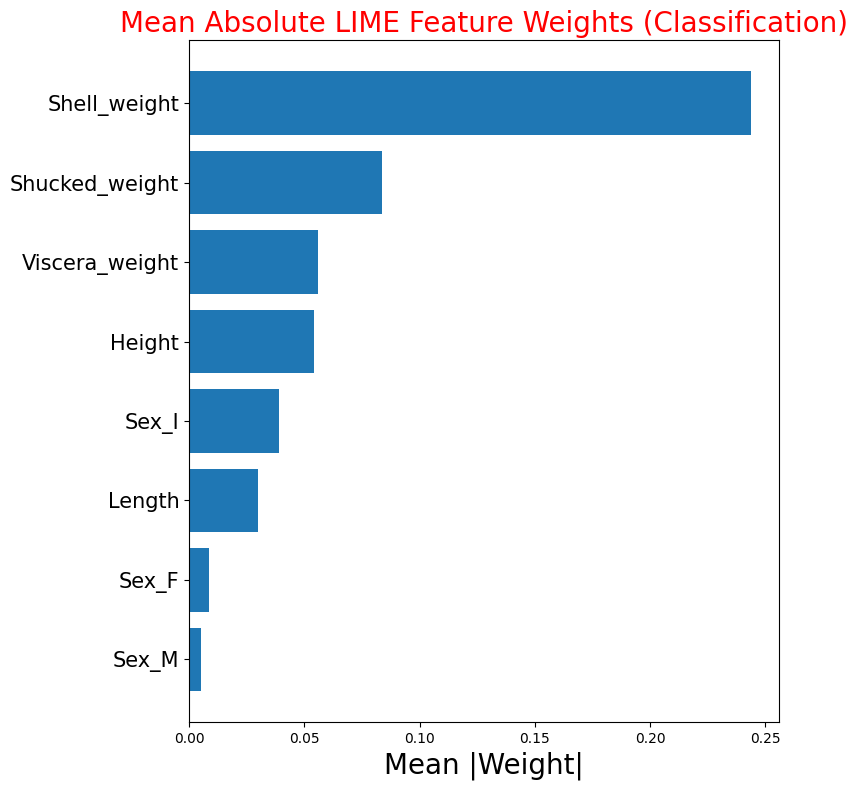

In [256]:
# Calculate the absolute mean of LIME weights
abs_mean = lime_weights.abs().mean(axis=0)

# Convert to DataFrame for plotting
abs_mean = pd.DataFrame(data={'feature': abs_mean.index, 'abs_mean': abs_mean})
abs_mean = abs_mean.sort_values('abs_mean')

# Plot Absolute Mean Feature Importance
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 8))

y_ticks = range(len(abs_mean))
y_labels = abs_mean['feature']

plt.barh(y=y_ticks, width=abs_mean['abs_mean'])
plt.yticks(ticks=y_ticks, labels=y_labels, size=15)
plt.xlabel('Mean |Weight|', size=20)
plt.title('Mean Absolute LIME Feature Weights (Classification)', size=20, color="red")

plt.tight_layout()
plt.show()


## 13.3 Feature Trend

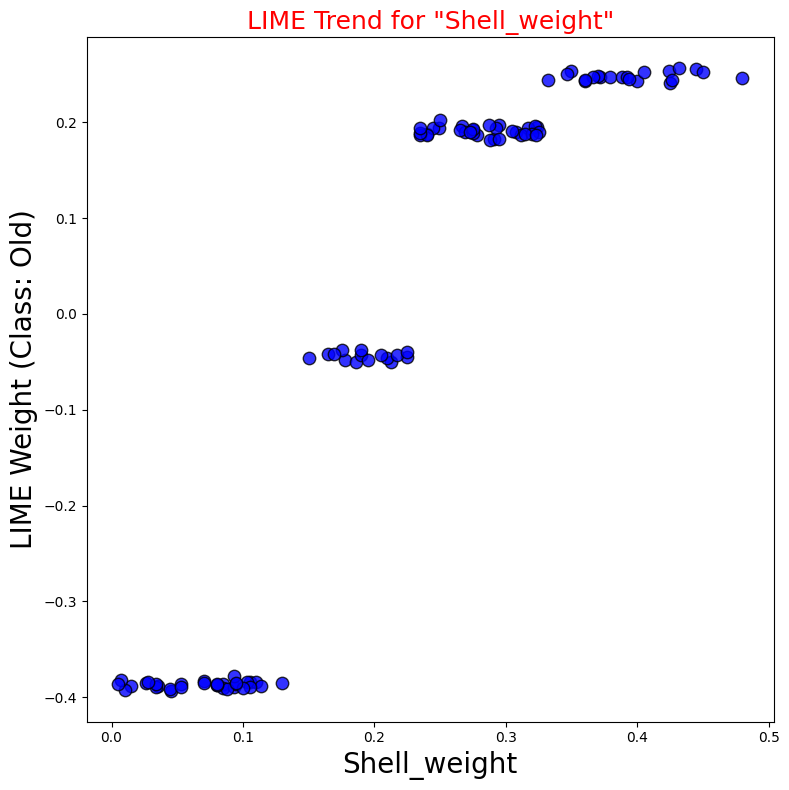

In [257]:
# Create the plot
fig, ax = plt.subplots(figsize=(8, 8))

# Choose the feature to inspect — make sure the name matches the one in your DataFrame
feature_name = 'Shell_weight'  # Use correct capitalization based on original dataset

# Get LIME weights (from the saved lime_weights DataFrame)
# and corresponding actual feature values from the first 100 instances to match the lime_weights size
feature_weight = lime_weights[feature_name]
feature_value = X_test[feature_name].iloc[:len(feature_weight)] # Select the same number of instances as the number of LIME explanations

# Scatter plot of feature value vs LIME weight
plt.scatter(x=feature_value, y=feature_weight,
            s=80, color='blue', edgecolor='black', alpha=0.8)

plt.ylabel('LIME Weight (Class: Old)', size=20)
plt.xlabel(feature_name, size=20)
plt.title(f'LIME Trend for "{feature_name}"', size=18, color="red")

plt.tight_layout()
plt.show()

Higher shell_weight increases likelihood of being Old

## 13.4 Beeswarm

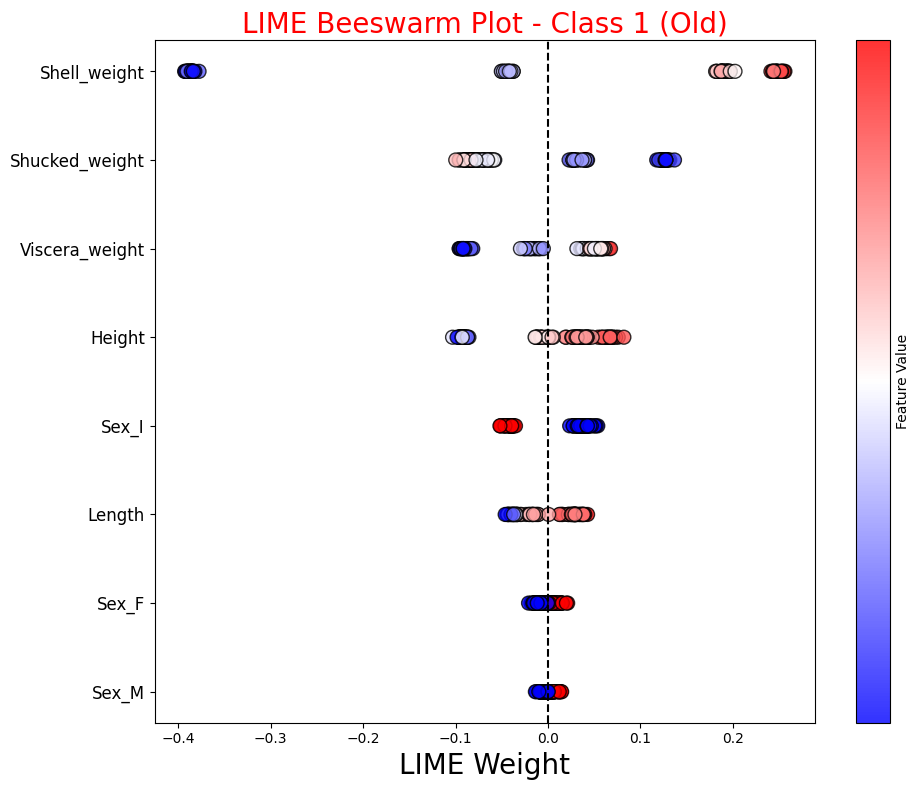

In [258]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))

y_ticks = range(len(abs_mean))
y_labels = abs_mean.feature

# Loop over features in order of abs mean weight
for i, feature in enumerate(y_labels):
    feature_weight = lime_weights[feature]
    feature_value = X_test[feature].iloc[0:100]  # Match the data used in lime_weights

    plt.scatter(x=feature_weight,
                y=[i] * len(feature_weight),
                c=feature_value,
                cmap='bwr',
                edgecolors='black',
                alpha=0.8,
                s=100)

# Add vertical line at 0
plt.axvline(x=0, color='black', linestyle='--')

# Colorbar for feature value scale
plt.colorbar(label='Feature Value', ticks=[])

# Set axis labels and ticks
plt.yticks(ticks=y_ticks, labels=y_labels, size=12)
plt.xlabel('LIME Weight', size=20)
plt.title('LIME Beeswarm Plot - Class 1 (Old)', size=20, color="red")

plt.tight_layout()
plt.show()


Positive weights → push prediction toward class 1 (Old)

Negative weights → push it away (toward Young)




#**By: Hiba, Wadiqa Fatima and Pooja**